In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import lightgbm as lgb
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

# Add parent directory to path for imports
import sys
sys.path.append('..')

# Import your VQVAE model and data loading utilities
from vq_vae_model import VQVAE,load_config
from VQ_VAE.vq_dataloader import load_fraud_data

In [2]:
# Cell 2: Load model with correct architecture
import os

# Go back to parent directory if needed
os.chdir('..')

# Path to your best model and its config (paths are relative to the parent directory)
model_path = 'saved_models/vq_vae/20250307_164851_vqvae-minimal/best_model_val_loss_1.2376.pt'
config_path = 'configs/vq_vae/vq_vae_test.config'  # Make sure this matches the training config

# Verify the model file exists
print(f"Current directory: {os.getcwd()}")
print(f"Model file exists: {os.path.exists(model_path)}")

# If the model file still doesn't exist, find where it might be
if not os.path.exists(model_path):
    # Try to locate potential model files
    import glob
    model_files = glob.glob('saved_models/**/*.pt', recursive=True)
    print(f"Available model files: {model_files}")
    
    # Let's use the first available model file if any
    if model_files:
        model_path = model_files[0]
        print(f"Using model: {model_path}")
    else:
        raise FileNotFoundError(f"No model files found")

# Load the config to ensure architecture matches
config = load_config(config_path)
vqvae_config = config.get('VQVAE', {})

# Load model directly from checkpoint
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load(model_path, map_location=device)

# Create model with exact same architecture as the saved one
model = VQVAE(
    input_dim=checkpoint["input_dim"],
    hidden_dims=vqvae_config.get('hidden_dims', [64, 32]),  # Use config values
    latent_dim=checkpoint["latent_dim"],
    num_embeddings=checkpoint["num_embeddings"],
    embedding_dim=checkpoint["embedding_dim"],
    commitment_cost=vqvae_config.get('commitment_cost', 0.005),
    decay=vqvae_config.get('decay', 0.99),
    dropout_rate=vqvae_config.get('dropout_rate', 0.1)
)

model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
model.eval()

print(f"Loaded model from {model_path}")
print(f"Model architecture: Codebook size = {model.num_embeddings}, Embedding dim = {model.embedding_dim}")
print(f"Hidden dimensions: {vqvae_config.get('hidden_dims', [64, 32])}")

Current directory: /home/alexkstern/fraudml
Model file exists: True
Loaded model from saved_models/vq_vae/20250307_164851_vqvae-minimal/best_model_val_loss_1.2376.pt
Model architecture: Codebook size = 64, Embedding dim = 16
Hidden dimensions: [64, 32]


/tmp/ipykernel_10143/1485268753.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


In [3]:
# Cell 3: Load the raw dataset to get labels
train_dataset = load_dataset("stanpony/european_credit_card_fraud_dataset", split='train')
val_dataset = load_dataset("stanpony/european_credit_card_fraud_dataset", split='validation')
test_dataset = load_dataset("stanpony/european_credit_card_fraud_dataset", split='test')

# Convert to pandas DataFrames
train_df = pd.DataFrame(train_dataset)
val_df = pd.DataFrame(val_dataset)
test_df = pd.DataFrame(test_dataset)

print(f"Train set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")

# Check class distribution
print("\nFraud distribution:")
print(f"Train: {train_df['Class'].value_counts()}")
print(f"Validation: {val_df['Class'].value_counts()}")
print(f"Test: {test_df['Class'].value_counts()}")

Train set: 12378 samples
Validation set: 1547 samples
Test set: 1548 samples

Fraud distribution:
Train: 0    12000
1      378
Name: Class, dtype: int64
Validation: 0    1500
1      47
Name: Class, dtype: int64
Test: 0    1500
1      48
Name: Class, dtype: int64


In [4]:
# Cell 4: Load data with the same preprocessing as training
config_path = 'configs/vq_vae/vq_vae_test.config'  # Path to your config file
data = load_fraud_data(config_path=config_path)

train_loader = data['dataloaders']['train']
val_loader = data['dataloaders']['val']
test_loader = data['dataloaders']['test']
stats_dict = data['stats_dict']

print(f"Data loaded with normalization stats: {stats_dict}")

Loaded configuration from configs/vq_vae/vq_vae_test.config
Using all classes: 12378 samples
Normalization statistics: {'Time': {'mean': 93950.12481822589, 'std': 47453.14126639548}, 'Amount': {'mean': 89.01172645015349, 'std': 241.8942806171708}}
Using all classes: 12378 samples
Using all classes: 1547 samples
Using all classes: 1548 samples
Data loaded with normalization stats: {'Time': {'mean': 93950.12481822589, 'std': 47453.14126639548}, 'Amount': {'mean': 89.01172645015349, 'std': 241.8942806171708}}


In [5]:
# Cell 5: Extract features using the model
def extract_features_and_labels(dataloader, dataset_df):
    # Lists to store features and labels
    all_encodings = []
    all_indices = []
    
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            # Move batch to device
            batch = batch.to(device)
            
            # Get encodings (discrete tokens)
            encodings = model.encode_to_indices(batch)
            print(encodings)
            
            # Store encodings and batch indices
            all_encodings.append(encodings.cpu().numpy())
            
            # Calculate current batch indices correctly
            start_idx = i * dataloader.batch_size
            end_idx = min(start_idx + len(batch), len(dataloader.dataset))
            all_indices.extend(list(range(start_idx, end_idx)))
            
    
    # Concatenate all encodings
    all_encodings = np.concatenate(all_encodings)
    
    # Create DataFrame with encodings and labels
    encodings_df = pd.DataFrame({
        'encoding': all_encodings,
        'index': all_indices
    })
    
    # Sort by index to ensure alignment with the original dataset
    encodings_df = encodings_df.sort_values('index').reset_index(drop=True)
    
    # Make sure encodings and labels are aligned
    if len(encodings_df) != len(dataset_df):
        print(f"Warning: Number of encodings ({len(encodings_df)}) doesn't match dataset size ({len(dataset_df)})")
        # Trim to the smaller size if necessary
        min_size = min(len(encodings_df), len(dataset_df))
        encodings_df = encodings_df.iloc[:min_size]
        labels = dataset_df['Class'].values[:min_size]
    else:
        labels = dataset_df['Class'].values
    
    return encodings_df['encoding'].values, labels

# Extract features and labels
print("Extracting features from train set...")
train_features, train_labels = extract_features_and_labels(train_loader, train_df)

print("Extracting features from validation set...")
val_features, val_labels = extract_features_and_labels(val_loader, val_df)

print("Extracting features from test set...")
test_features, test_labels = extract_features_and_labels(test_loader, test_df)

print(f"\nExtracted features:")
print(f"Train: {train_features.shape}")
print(f"Validation: {val_features.shape}")
print(f"Test: {test_features.shape}")

Extracting features from train set...


tensor([26, 20, 12, 30, 20, 38, 54,  1,  1,  1, 56, 62, 34, 54,  5, 59, 60, 37,
        46, 35, 13, 19, 57,  9, 48, 10, 19, 34, 18, 13, 13, 20])
tensor([ 9, 36, 38, 11, 37, 49,  0, 49, 30, 35, 50, 40, 62, 20, 38, 13, 13,  3,
        54, 13, 46, 60,  6,  6, 54,  6, 11, 40, 55, 44, 46, 61])
tensor([34, 18, 13, 50, 47, 40, 36, 48, 20,  1, 15, 27,  1,  6, 17, 36, 50,  1,
        20, 13, 38, 57,  8, 49,  9, 11, 20, 63, 10,  8, 37, 38])
tensor([57, 18, 61,  6, 54, 20, 56, 58, 17, 30, 25,  6,  0, 44,  6, 30, 18, 25,
        25, 13, 13, 63, 40,  6,  1,  6, 54, 13, 25, 40,  6, 40])
tensor([37, 50, 39, 14,  9, 62, 15, 47, 18, 18,  9, 38, 38, 15, 54, 34, 54, 38,
        44,  1, 39, 54, 61, 44, 40,  6,  3,  9, 17,  6,  1, 38])
tensor([13, 34,  6, 49, 38, 38, 18, 54, 46, 38, 20, 12, 26, 25,  0, 34, 19, 62,
        40, 49, 45, 18, 57,  1, 10, 62,  6, 31, 46,  6, 62, 55])
tensor([17, 34, 20, 38, 34, 46, 44, 12,  6,  4,  6, 12, 47, 39, 22, 38, 46,  6,
        58, 44, 36, 54, 13, 20, 18, 13, 13, 25, 11

In [6]:
# Cell 6: Train LGBM classifier on the extracted features
# Reshape features for LGBM 
train_features_processed = train_features.reshape(-1, 1)
val_features_processed = val_features.reshape(-1, 1)
test_features_processed = test_features.reshape(-1, 1)

print(f"Processed feature shape: {train_features_processed.shape}")

# Create LGBM datasets
train_data = lgb.Dataset(train_features_processed, label=train_labels)
val_data = lgb.Dataset(val_features_processed, label=val_labels, reference=train_data)

# Parameters
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Train model
print("Training LightGBM classifier...")
model_lgb = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, val_data],
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

Processed feature shape: (12378, 1)
Training LightGBM classifier...
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	training's auc: 0.599423	valid_1's auc: 0.438504


Test Accuracy: 0.9690
Test AUC: 0.3946

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1500
           1       0.00      0.00      0.00        48

    accuracy                           0.97      1548
   macro avg       0.48      0.50      0.49      1548
weighted avg       0.94      0.97      0.95      1548



/home/alexkstern/miniconda3/envs/credit_vae/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexkstern/miniconda3/envs/credit_vae/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexkstern/miniconda3/envs/credit_vae/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

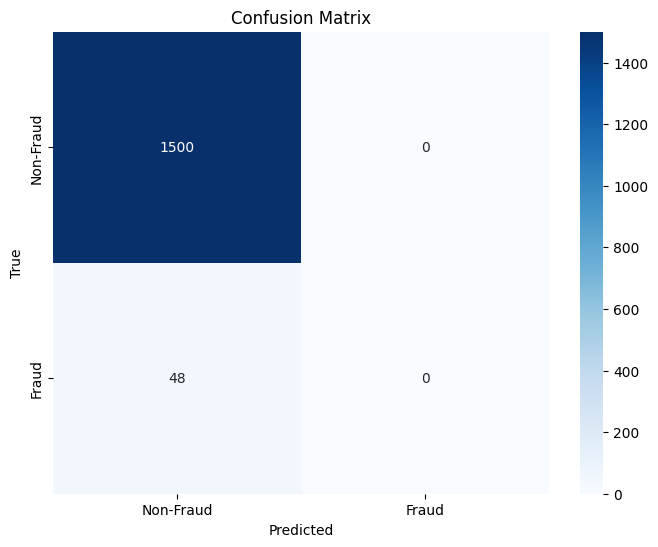

In [7]:
# Cell 7: Evaluate the classifier
# Make predictions
test_preds_proba = model_lgb.predict(test_features_processed)
test_preds = (test_preds_proba > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(test_labels, test_preds)
auc = roc_auc_score(test_labels, test_preds_proba)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc:.4f}")
print("\nClassification Report:")
print(classification_report(test_labels, test_preds))

# Plot confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Fraud', 'Fraud'], 
            yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Training MLP classifier on VQ-VAE features...
MLP Test Accuracy: 0.9690
MLP Test AUC: 0.7831

Classification Report (MLP):
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1500
           1       0.00      0.00      0.00        48

    accuracy                           0.97      1548
   macro avg       0.48      0.50      0.49      1548
weighted avg       0.94      0.97      0.95      1548



/home/alexkstern/miniconda3/envs/credit_vae/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexkstern/miniconda3/envs/credit_vae/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexkstern/miniconda3/envs/credit_vae/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

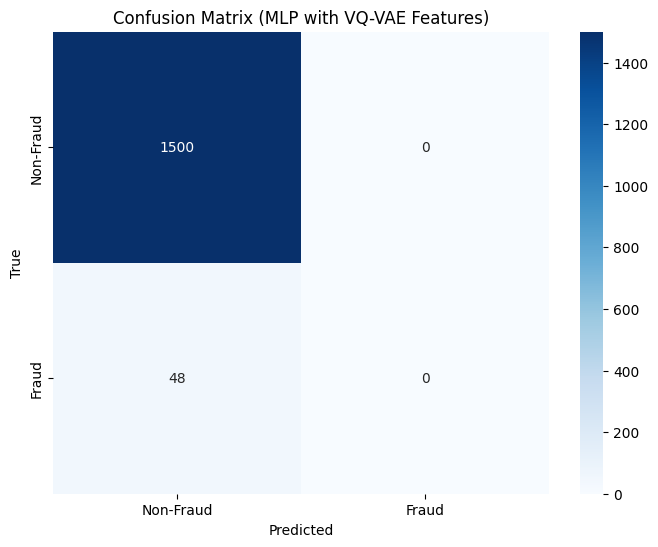

In [10]:
# Cell 8: Train MLP classifier on VQ-VAE features (without scaling)
from sklearn.neural_network import MLPClassifier

# Train MLP classifier
print("Training MLP classifier on VQ-VAE features...")
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),  # Two hidden layers
    activation='relu',
    solver='adam',
    alpha=0.0001,  # L2 penalty
    batch_size=32,
    learning_rate='adaptive',
    max_iter=200,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=42
)

mlp.fit(train_features_processed, train_labels)

# Make predictions
test_preds_proba_mlp = mlp.predict_proba(test_features_processed)[:, 1]
test_preds_mlp = mlp.predict(test_features_processed)

# Calculate metrics
accuracy_mlp = accuracy_score(test_labels, test_preds_mlp)
auc_mlp = roc_auc_score(test_labels, test_preds_proba_mlp)

print(f"MLP Test Accuracy: {accuracy_mlp:.4f}")
print(f"MLP Test AUC: {auc_mlp:.4f}")
print("\nClassification Report (MLP):")
print(classification_report(test_labels, test_preds_mlp))

# Plot confusion matrix
cm_mlp = confusion_matrix(test_labels, test_preds_mlp)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Fraud', 'Fraud'], 
            yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (MLP with VQ-VAE Features)')
plt.show()

Training baseline MLP classifier on original features...
Baseline MLP Test Accuracy: 0.9935
Baseline MLP Test AUC: 0.9456

Classification Report (Baseline MLP):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1500
           1       0.93      0.85      0.89        48

    accuracy                           0.99      1548
   macro avg       0.96      0.93      0.94      1548
weighted avg       0.99      0.99      0.99      1548



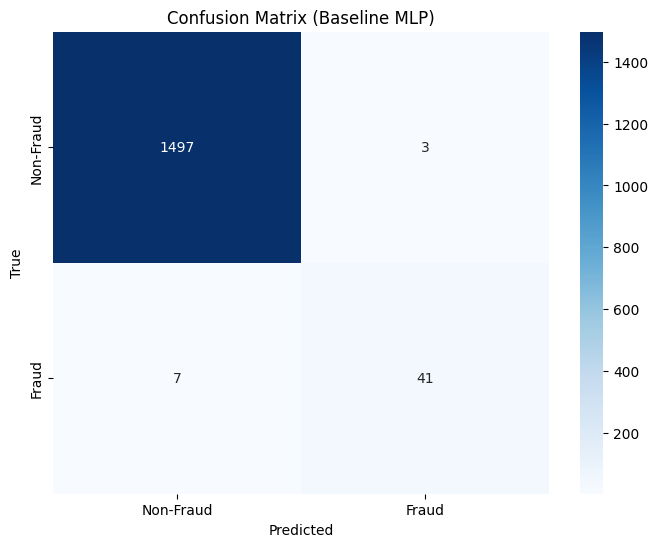

In [12]:
# Cell 9: Train baseline MLP on original features (without scaling)
# Train baseline MLP classifier
# Prepare original features (excluding 'Class' and 'original_index')
feature_cols = [col for col in train_df.columns if col not in ['Class', 'original_index']]
X_train = train_df[feature_cols].values
X_val = val_df[feature_cols].values
X_test = test_df[feature_cols].values
print("Training baseline MLP classifier on original features...")
mlp_baseline = MLPClassifier(
    hidden_layer_sizes=(64, 32),  # Same architecture as VQ-VAE MLP
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size=32,
    learning_rate='adaptive',
    max_iter=200,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=42
)

mlp_baseline.fit(X_train, train_labels)

# Make predictions
test_preds_proba_mlp_baseline = mlp_baseline.predict_proba(X_test)[:, 1]
test_preds_mlp_baseline = mlp_baseline.predict(X_test)

# Calculate metrics
accuracy_mlp_baseline = accuracy_score(test_labels, test_preds_mlp_baseline)
auc_mlp_baseline = roc_auc_score(test_labels, test_preds_proba_mlp_baseline)

print(f"Baseline MLP Test Accuracy: {accuracy_mlp_baseline:.4f}")
print(f"Baseline MLP Test AUC: {auc_mlp_baseline:.4f}")
print("\nClassification Report (Baseline MLP):")
print(classification_report(test_labels, test_preds_mlp_baseline))

# Plot confusion matrix
cm_mlp_baseline = confusion_matrix(test_labels, test_preds_mlp_baseline)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_mlp_baseline, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Fraud', 'Fraud'], 
            yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Baseline MLP)')
plt.show()

In [8]:
# Cell 8: Train a baseline model using original features for comparison
# Prepare original features (excluding 'Class' and 'original_index')
feature_cols = [col for col in train_df.columns if col not in ['Class', 'original_index']]
X_train = train_df[feature_cols].values
X_val = val_df[feature_cols].values
X_test = test_df[feature_cols].values

# Create LGBM datasets with original features
train_data_orig = lgb.Dataset(X_train, label=train_labels)
val_data_orig = lgb.Dataset(X_val, label=val_labels, reference=train_data_orig)

# Train model on original features
print("Training baseline LightGBM classifier on original features...")
model_lgb_orig = lgb.train(
    params,
    train_data_orig,
    num_boost_round=100,
    valid_sets=[train_data_orig, val_data_orig],
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

# Make predictions
test_preds_proba_orig = model_lgb_orig.predict(X_test)
test_preds_orig = (test_preds_proba_orig > 0.5).astype(int)

# Calculate metrics
accuracy_orig = accuracy_score(test_labels, test_preds_orig)
auc_orig = roc_auc_score(test_labels, test_preds_proba_orig)

print(f"Baseline Test Accuracy: {accuracy_orig:.4f}")
print(f"Baseline Test AUC: {auc_orig:.4f}")
print("\nClassification Report (Baseline):")
print(classification_report(test_labels, test_preds_orig))

Training baseline LightGBM classifier on original features...
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's auc: 0.993729	valid_1's auc: 0.964035
Baseline Test Accuracy: 0.9690
Baseline Test AUC: 0.9850

Classification Report (Baseline):
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1500
           1       0.00      0.00      0.00        48

    accuracy                           0.97      1548
   macro avg       0.48      0.50      0.49      1548
weighted avg       0.94      0.97      0.95      1548



/home/alexkstern/miniconda3/envs/credit_vae/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexkstern/miniconda3/envs/credit_vae/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexkstern/miniconda3/envs/credit_vae/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Performance Comparison:
          VQ-VAE Features  Original Features  Difference
Metric                                                  
Accuracy         0.968992           0.968992    0.000000
AUC              0.589424           0.984958   -0.395535


<Figure size 1000x600 with 0 Axes>

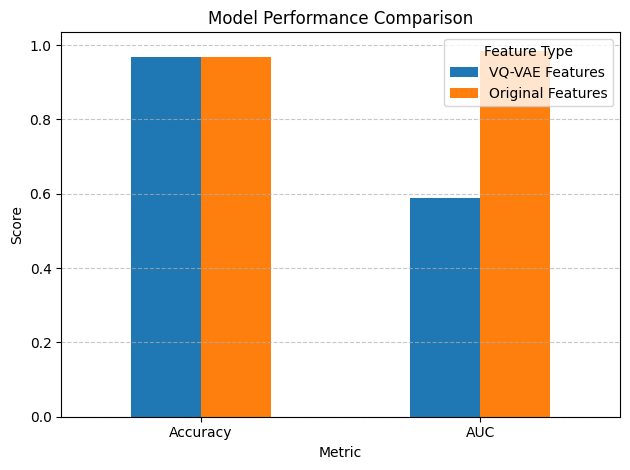


Conclusion:
The VQ-VAE features performed WORSE than the original features.
This demonstrates the potential of using VQ-VAE for learning meaningful discrete representations of credit card transactions.


In [9]:
# Cell 9: Compare performance
# Compare VQ-VAE features with original features
metrics = {
    'Metric': ['Accuracy', 'AUC'],
    'VQ-VAE Features': [accuracy, auc],
    'Original Features': [accuracy_orig, auc_orig],
    'Difference': [accuracy - accuracy_orig, auc - auc_orig]
}

metrics_df = pd.DataFrame(metrics)
metrics_df.set_index('Metric', inplace=True)

print("Performance Comparison:")
print(metrics_df)

# Plot comparison
plt.figure(figsize=(10, 6))
metrics_df[['VQ-VAE Features', 'Original Features']].plot(kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Feature Type')
plt.tight_layout()
plt.show()

# Add conclusion
print("\nConclusion:")
if auc > auc_orig:
    print("The VQ-VAE features performed BETTER than the original features.")
elif auc < auc_orig:
    print("The VQ-VAE features performed WORSE than the original features.")
else:
    print("The VQ-VAE features performed SIMILARLY to the original features.")

print("This demonstrates the potential of using VQ-VAE for learning meaningful discrete representations of credit card transactions.")